# Meteorite Landings - Problematic and Data Analysis

Data source: [https://www.kaggle.com/nasa/meteorite-landings](https://www.kaggle.com/nasa/meteorite-landings)
<br>
Meteorite classification: [https://en.wikipedia.org/wiki/Meteorite_classification](https://en.wikipedia.org/wiki/Meteorite_classification)

## Data Quality

According to the [Kaggle Dataset Page](https://www.kaggle.com/nasa/meteorite-landings), a few dates are incorrectly parsed
and are either < 860 BCE or > 2016. There may be some other errors.

Some entries have a latitude-longitude value of 0N/0E, they are probably incorrect because these are meteorites whose precise
landing could not be know (e.g. meteor spotted landing over the ocean), or whose landing location was simply not reported.
It is worth noting that many of these were discovered in Antartica, but no better location information is recorded in the dataset.

Just for good measure, let's check the indicated masses are correct, we remove masses indicated as 0.0.
Below we filter the data, indicate the number of invalid entries and keep the incomplete/invalid entries in separate datasets.

In [1]:
import csv, re

RAW_DATA_FILE = "MeteoriteLandings.csv"
VALID_DATA_FILE = f"{RAW_DATA_FILE[:-4]}_Valid.csv"
INVALID_DATA_FILE = f"{RAW_DATA_FILE[:-4]}_Invalid.csv"

with open(RAW_DATA_FILE) as csv_file, open(VALID_DATA_FILE, mode='w') as valid_file, open(INVALID_DATA_FILE, mode='w') as invalid_file:
    # Initialize writers and readers
    reader = csv.DictReader(csv_file)
    valid_writer = csv.DictWriter(valid_file, reader.fieldnames)
    valid_writer.writeheader()
    invalid_writer = csv.DictWriter(invalid_file, reader.fieldnames)
    invalid_writer.writeheader()

    # Prepare regexes for date, mass and lat-lon
    date_regex = re.compile(r'^\d+/\d+/(\d+) \d+:\d+:\d+ (AM|PM)$')
    mass_regex = re.compile(r'^\d+(.\d+)?$')
    latlon_regex = re.compile(r'^\((-?\d+\.\d+), (-?\d+\.\d+)\)$')

    # Tells us if a line is malformed
    def valid(line) -> bool:
        # Check date
        date = line['year']
        match = date_regex.match(date)
        if match:
            # Check year of date
            year = int(match.group(1))
            if year > 2016 or year < 860:
                return False
        else:
            return False

        # Check mass (exclude mass = 0 or invalid)
        mass = line['mass (g)']
        match = mass_regex.match(mass)
        if match:
            value = float(mass)
            if value <= 0:
                return False
        else:
            return False

        # Check latlon
        latlon = line['GeoLocation']
        match = latlon_regex.match(latlon)
        if match:
            # Check each value
            lat, lon = float(match.group(1)), float(match.group(2))
            if lat == 0 or lon == 0:
                return False
        else:
            return False
        
        return True

    # Filter entries
    valid_num, invalid_num, total_num = 0, 0, 0
    for raw_line in reader:
        total_num += 1
        if not valid(raw_line):
            # Write in invalid writer
            invalid_num += 1
            invalid_writer.writerow(raw_line)
        else:
            # Write in valid writer
            valid_num += 1
            valid_writer.writerow(raw_line)

    # Display results
    valid_percentage = int(valid_num * 100 / total_num)
    print(f"{valid_num} valid lines out of {total_num} lines ({valid_percentage}%)")
    print(f"{invalid_num} invalid lines out of {total_num} lines ({100 - valid_percentage}%)")

31687 valid lines out of 45716 lines (69%)
14029 invalid lines out of 45716 lines (31%)


We see about 69% of our dataset contains **both** valid years and coordinates. Later we could separate the invalid data into different datasets, depending on which data is missing: year, location, or both.

## Problematic

**Are all meteors striking the earth equal in terms of mass and composition? If not, do some types strike more often than others?** We could plot the number of recorded falls vs. class of meteorites, also vs. meteorite mass. 

**Do some classes of meteors tend to strike the earth on different latitudes?** We could link this with a geographical representation to see whether this is true. Both could be related to the possibly different orbits that different classes of asteroids follow around the Sun.

**Does worldwide strike frequency fluctuate over time?** Did we record more strikes during years a comet passed by? We could plot asteroid strike frequency over time and add markers for years a comet passed by Earth.

## Data Analysis

As seen above, about 69% of our dataset (31687 lines) contains both valid year and location.

How many classes are listed in the file and how are they distributed?

What is the range of their mass and how is their mass distributed?

Number of classes: 390
Min mass = 0.01, max mass = 60000000.0


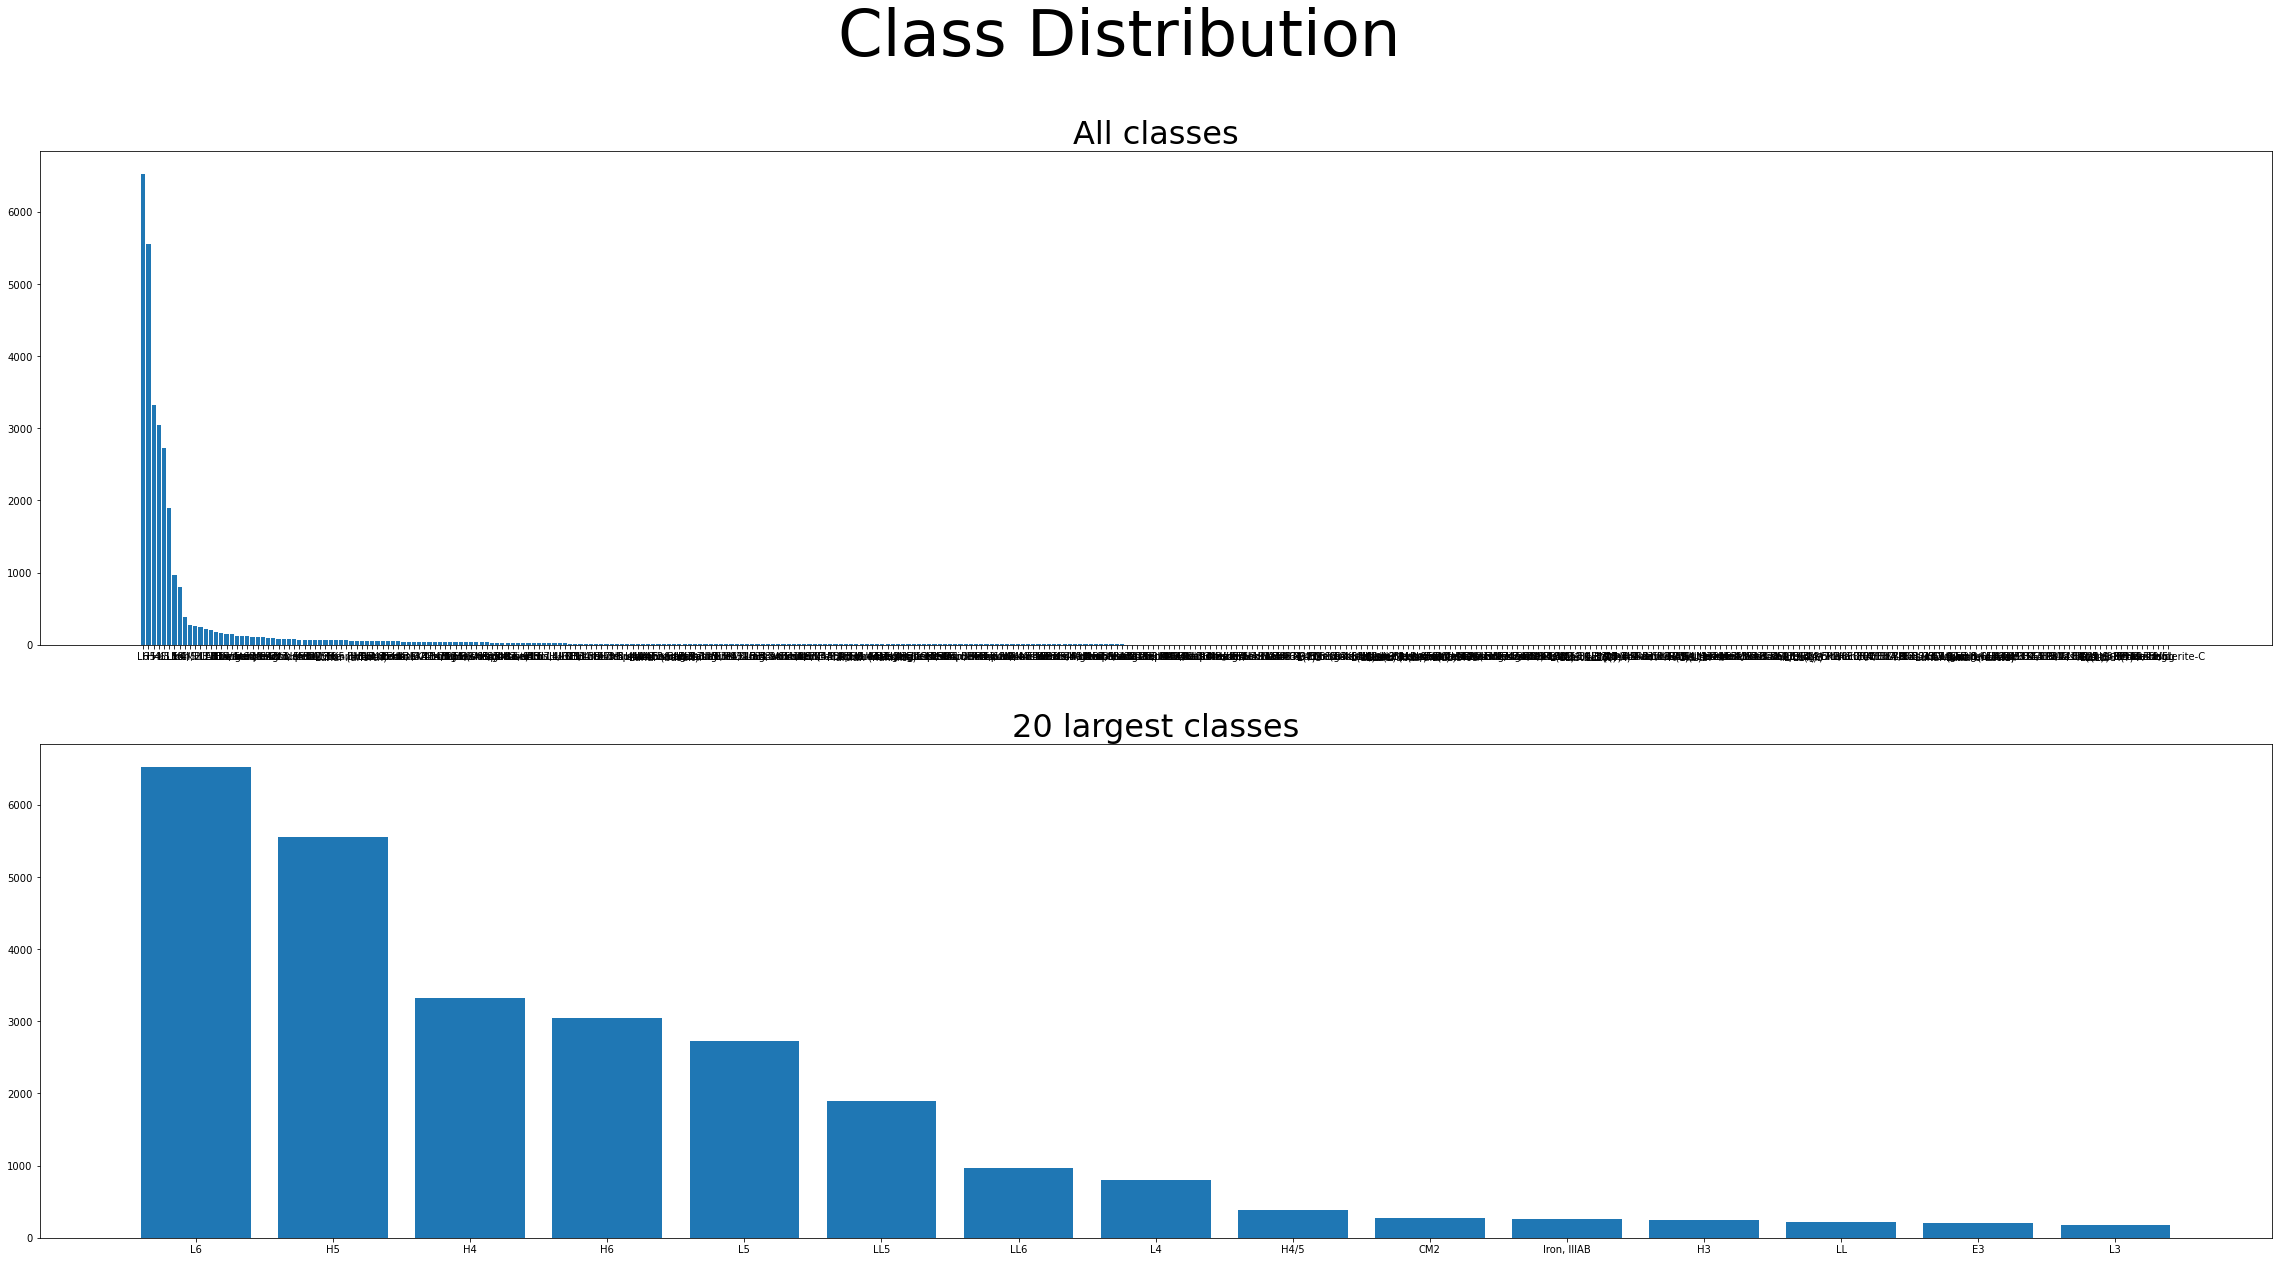

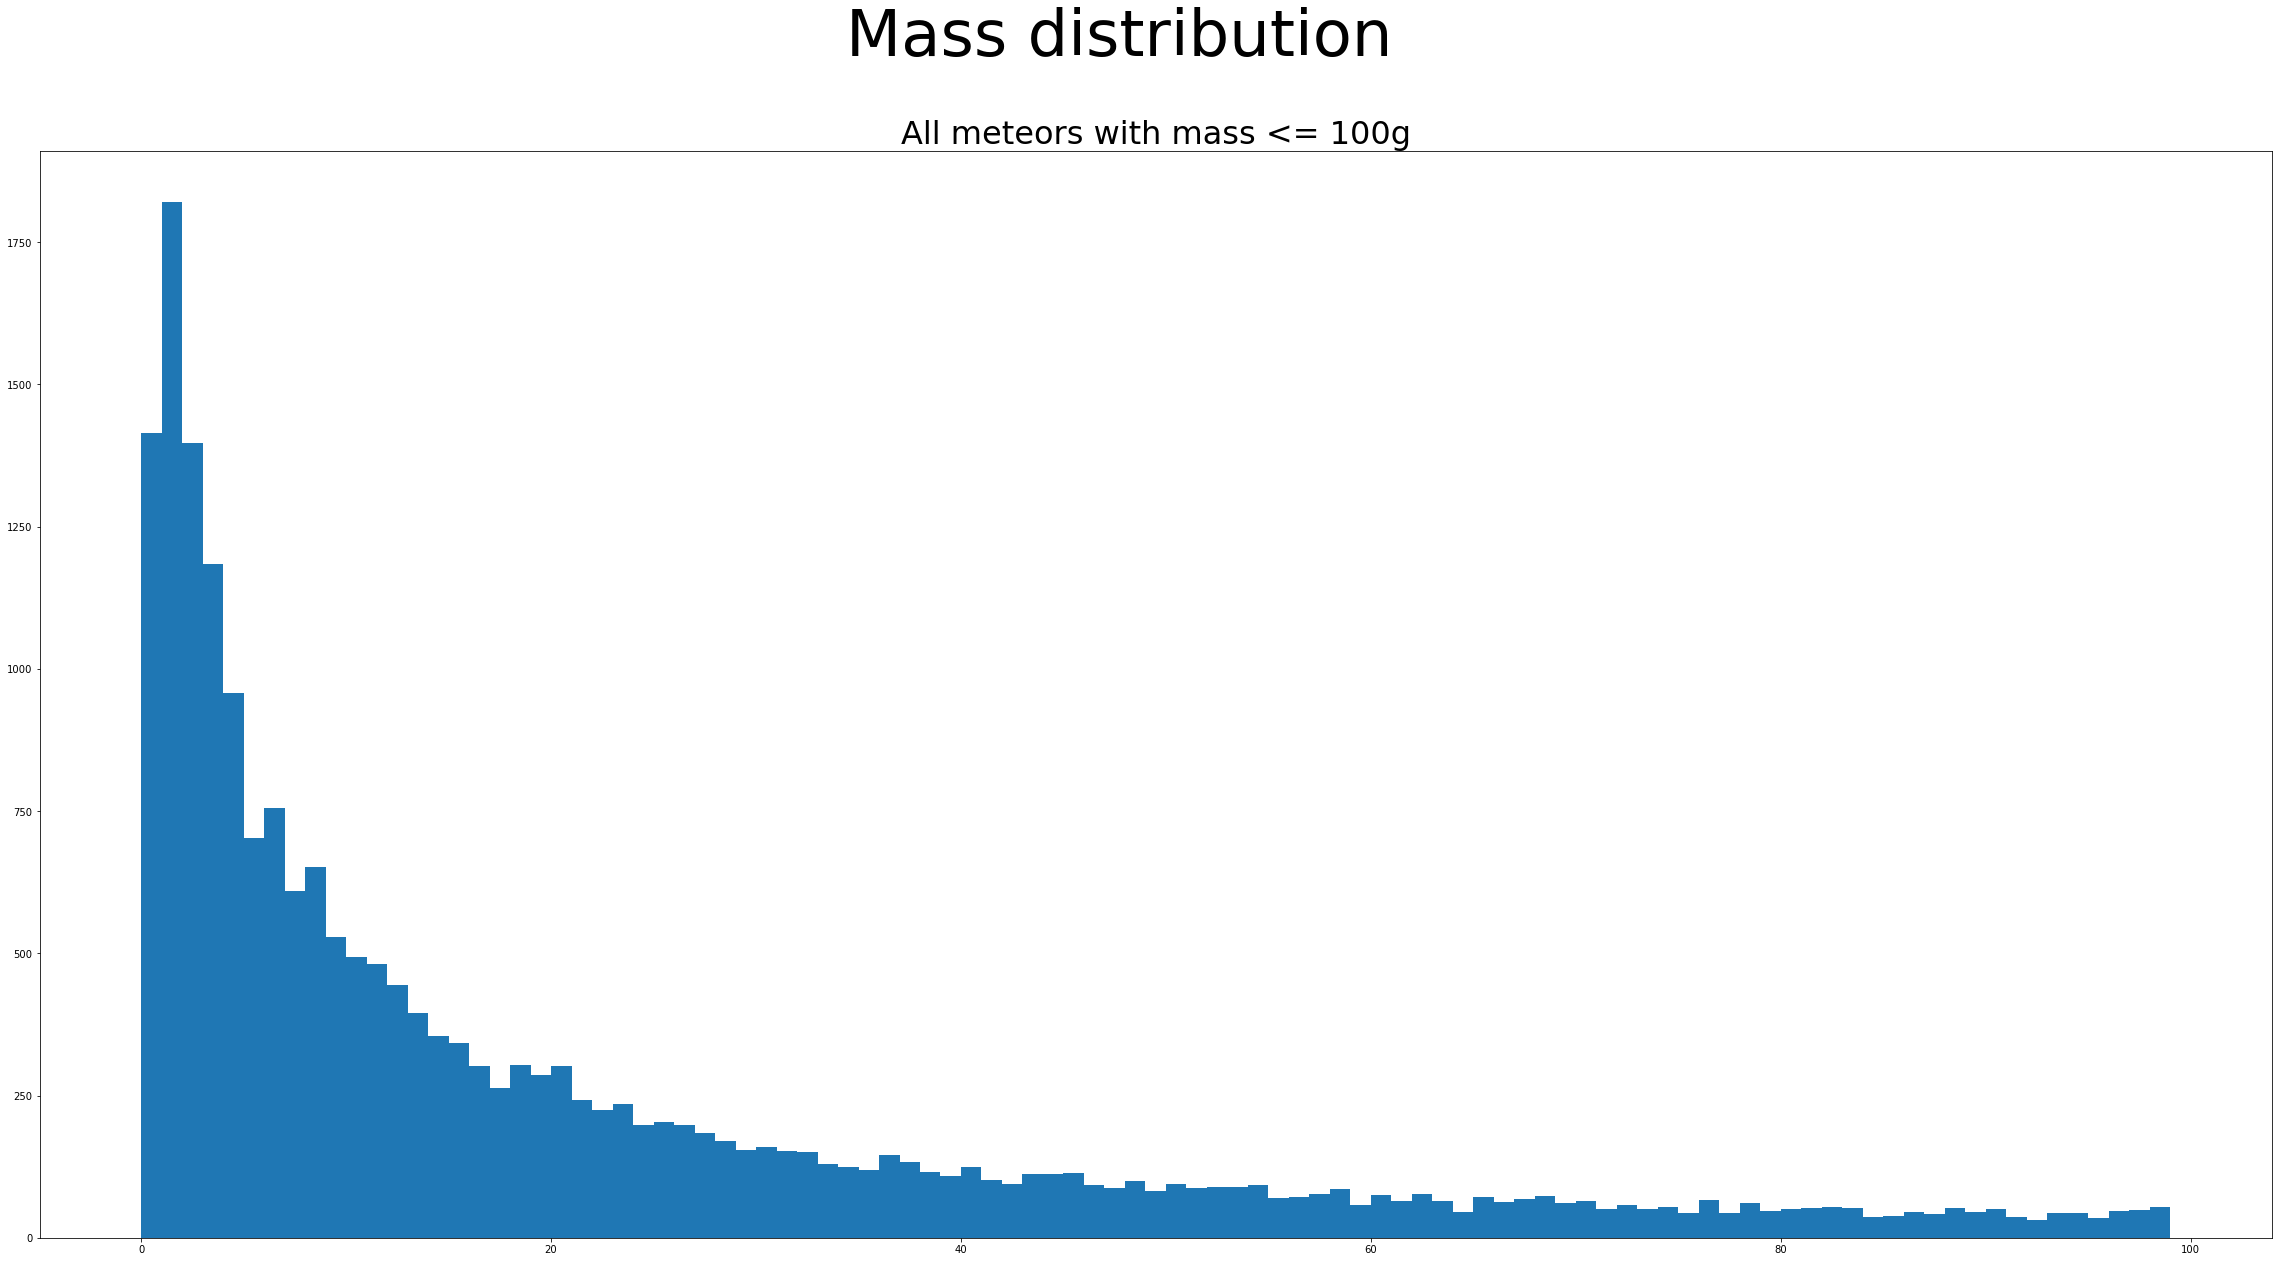

In [3]:
from collections import OrderedDict
import math, matplotlib.pyplot as plt

masses = []
with open(VALID_DATA_FILE) as valid_file:
    # Initialize reader
    reader = csv.DictReader(valid_file)

    # Gather statistics
    classes = dict()
    min_mass, max_mass = math.inf, 0
    for line in reader:
        class_ = line['recclass']
        if class_ in classes:
            classes[class_] += 1
        else:
            classes[class_] = 1

        mass = float(line['mass (g)'])
        masses.append(mass)
        if mass < min_mass:
            min_mass = mass
        if mass > max_mass:
            max_mass = mass

    print(f"Number of classes: {len(classes.keys())}")
    print(f"Min mass = {min_mass}, max mass = {max_mass}")

    # Histogram for classes
    sorted_classes = OrderedDict({ k:v for k, v in sorted(list(classes.items()), key=lambda elem: elem[1], reverse=True) })
    plt.figure(figsize=(40, 20))
    plt.suptitle("Class Distribution", fontsize=64)
    plt.subplot(2, 1, 1)
    plt.title("All classes", fontsize=32)
    plt.bar(sorted_classes.keys(), sorted_classes.values())

    largest = OrderedDict({ k:v for k, v in list(sorted_classes.items())[:15] })
    plt.subplot(2, 1, 2)
    plt.title("20 largest classes", fontsize=32)
    plt.bar(largest.keys(), largest.values())
    
    # Histogram for mass
    plt.figure(figsize=(40, 20))
    plt.suptitle("Mass distribution", fontsize=64)
    bins = list(range(100))
    plt.title("All meteors with mass <= 100g", fontsize=32)
    plt.hist(masses, bins=bins)

We can see the 10 classes with the largest number of elements are: L6, H5, H4, H6, L5, LL5, LL6, L5, H4/5, CM2